# Defect rate comparison
**SM Lambrick**

This notebook analyses SHeM data comparing three different defect rates in Monolayer MoS<sub>2</sub>. The script makes use of some standard python module as well as the `shem_spot_profile` module available on [Github](https://github.com/slambrick/SHeM-diffraction-analysis). The notebook supports the publication "Defect density quantification in monolayer MoS<sub>2</sub> using helium atom micro-diffraction".

In [2]:
import numpy as np
import SHeM_diffraction_analysis.shem_spot_profile as ssp
import scipy
import copy
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
from scipy.interpolate import splrep, BSpline
import seaborn as sns
import matplotlib as mpl
colours = sns.color_palette()

Key datasets for the diffraction with defect rate analysis.

| Temperature | Sample 1a |	Sample 2   | Sample 3 |
|-------------|-----------|------------|----------|
| 120C	      |multiZ00182|multiZ000029|multiZ000055|       
|	          |Alpha=137.5|Alpha=102.5deg|Alpha=75deg|     
| 120C	      |multiZ00185|	           |multiZ000059|         
|	          |Alpha=82.5 |		       |Alpha=132.5deg|       
| 200C	      |multiZ00157|multiZ000018|multiZ000063|       
|             |Alpha=82.5 |Alpha=105deg|Alpha = 132.5deg|   
| 200C	      |multiZ00178|            |multiZ000068|      
|             |Alpha=137.5|            |Alpha = 75deg|      

Data analysis process (seperate for each temperature):
1. Import indiviudal scans.
2. Choose one of the scans as the "baseline scan", this one will not be scaled.
3. Match the background scans for each dataset to get the difference in diffraction intensity. 
4. Remove the background and scale with intensity for all the scans to create normalised data.
5. Fit Gaussians to get the integrated size of the diffraction scans.
6. Plot the magnitudes of the diffraction peaks as a function of defect density.

## 1. Import key scans

Only the key datasets are imported here. Seperate scripts for each of the 3 key samples are used to identify the principle azimuths.

### Sample 1a 'Pristine'

First is the data for the 'pristine' sample. We have 4 datasets at 2 temperatures along 2 (equivalent) principle azimuths.

Text(0.5, 1.0, '120C, azimuth 2, $\\alpha=137.5^\\circ$')

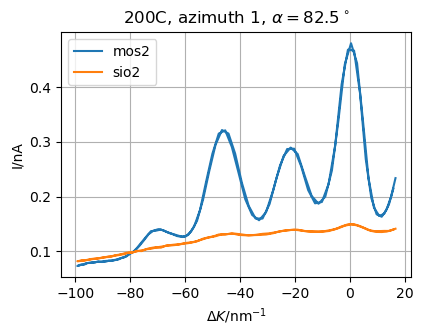

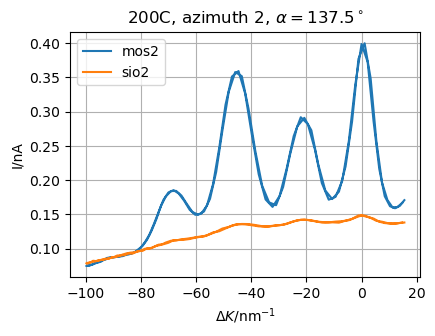

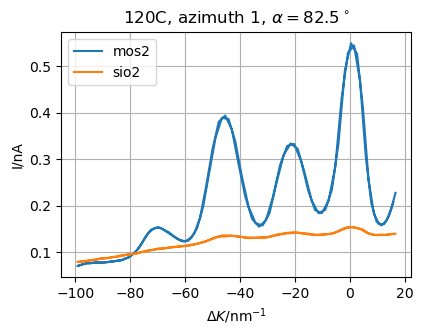

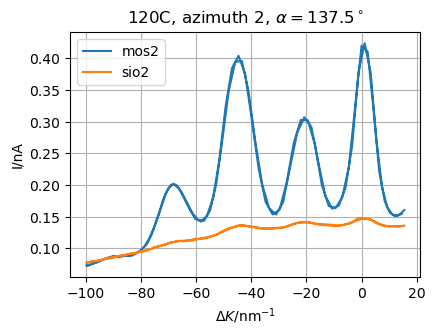

In [5]:
path_name = 'data/2023_12_defect1_repeat_5um_hbn_sub'
z_zero = 1.13e6
s1a_az1_200 = ssp.SpotProfile.import_ashem(157, path_name, z_zero = z_zero)
f, a, s1a_az1_mos2_200 = s1a_az1_200.line_plot_diffraction(82.5, scan=0, label='mos2')
_, _, s1a_az1_sio2_200 = s1a_az1_200.line_plot_diffraction(82.5, scan=1, ax=a, label='sio2')
a.set_title('200C, azimuth 1, $\\alpha=82.5^\\circ$')

z_zero = 1.2e6
s1a_az2_200 = ssp.SpotProfile.import_ashem(178, path_name, z_zero = z_zero)
f, a, s1a_az2_mos2_200 = s1a_az2_200.line_plot_diffraction(137.5, scan=0, label='mos2')
_, _, s1a_az2_sio2_200 = s1a_az2_200.line_plot_diffraction(137.5, scan=1, ax=a, label='sio2')
a.set_title('200C, azimuth 2, $\\alpha=137.5^\\circ$')

z_zero = 1.13e6
s1a_az1_120 = ssp.SpotProfile.import_ashem(185, path_name, z_zero = z_zero)
f, a, s1a_az1_mos2_120 = s1a_az1_120.line_plot_diffraction(82.5, scan=0, label='mos2')
_, _, s1a_az1_sio2_120 = s1a_az1_120.line_plot_diffraction(82.5, scan=1, ax=a, label='sio2')
a.set_title('120C, azimuth 1, $\\alpha=82.5^\\circ$')

z_zero = 1.2e6
s1a_az2_120 = ssp.SpotProfile.import_ashem(182, path_name, z_zero = z_zero)
f, a, s1a_az2_mos2_120 = s1a_az2_120.line_plot_diffraction(137.5, scan=0, label='mos2')
_, _, s1a_az2_sio2_120 = s1a_az2_120.line_plot_diffraction(137.5, scan=1, ax=a, label='sio2')
a.set_title('120C, azimuth 2, $\\alpha=137.5^\\circ$')

### Sample 2

Sample 2 underwent a mild annealing, at 550C for 30min, this is the first 'defective' sample. We have data only along one principle azimuth here. The sample 2 scans are used as the baseline for the background removal and signal normalisation.

Using alpha = 105.0deg.
Using alpha = 105.0deg.


Text(0.5, 1.0, '200C, azimuth 1, $\\alpha=105^\\circ$')

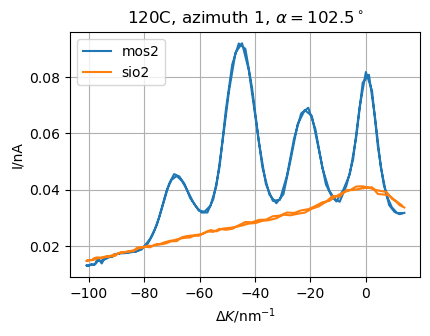

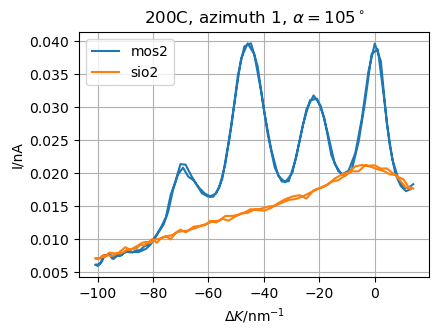

In [7]:
path_name = 'data/2023_09_defect_MoS2_5um_hbn_sub'
z_zero = 1.3e6
s2_az1_120 = ssp.SpotProfile.import_ashem(29, path_name, z_zero = z_zero)
f, a, s2_az1_mos2_120 = s2_az1_120.line_plot_diffraction(102.5, scan=0, label='mos2')
_, _, s2_az1_sio2_120 = s2_az1_120.line_plot_diffraction(102.5, scan=2, ax=a, label='sio2')
a.set_title('120C, azimuth 1, $\\alpha=102.5^\\circ$')

z_zero = 1.3e6
s2_az1_200 = ssp.SpotProfile.import_ashem(18, path_name, z_zero = z_zero)
f, a, s2_az1_mos2_200 = s2_az1_200.line_plot_diffraction(102.5, scan=0, label='mos2')
_, _, s2_az1_sio2_200 = s2_az1_200.line_plot_diffraction(102.5, scan=2, ax=a, label='sio2')
a.set_title('200C, azimuth 1, $\\alpha=105^\\circ$')

### Sample 3

Sample 3 has a higher defect rate and was annealed at 600C for 30min. We have data on 2 principle azimuths and at 2 temperatures.

Using alpha = 75.0deg.
Using alpha = 75.0deg.
Using alpha = 132.5deg.
Using alpha = 132.5deg.


Text(0.5, 1.0, '120C, azimuth 2, $\\alpha=75^\\circ$')

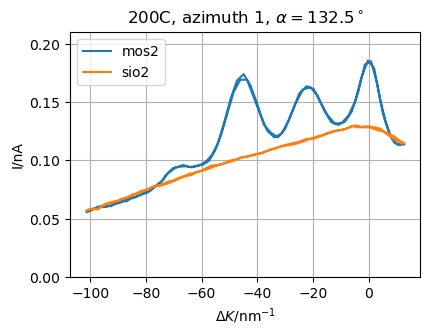

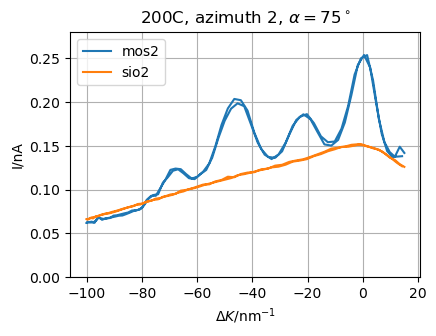

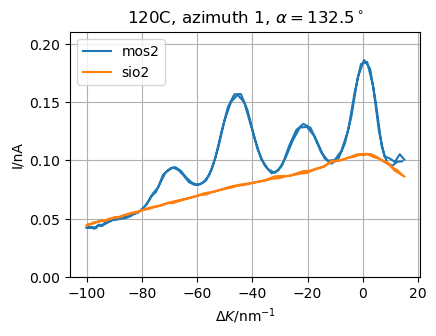

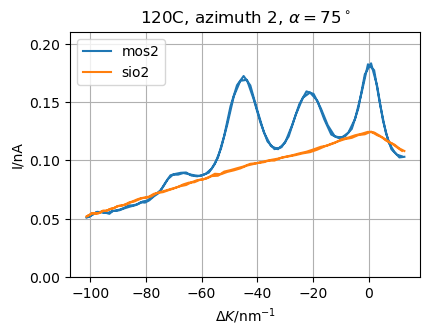

In [10]:
path_name = 'data/2023_11_defect2_MoS2_5um_hbn_sub'

z_zero = 1.36e6
s3_az1_200 = ssp.SpotProfile.import_ashem(63, path_name, z_zero = z_zero)
f, a, s3_az1_mos2_200 = s3_az1_200.line_plot_diffraction(132.5, scan=0, label='mos2')
_, _, s3_az1_sio2_200 = s3_az1_200.line_plot_diffraction(132.5, scan=2, ax=a, label='sio2')
a.set_ylim(0, 0.21)
a.set_title('200C, azimuth 1, $\\alpha=132.5^\\circ$')

z_zero = 1.23e6
s3_az2_200 = ssp.SpotProfile.import_ashem(68, path_name, z_zero = z_zero)
f, a, s3_az2_mos2_200 = s3_az2_200.line_plot_diffraction(75, scan=0, label='mos2')
_, _, s3_az2_sio2_200 = s3_az2_200.line_plot_diffraction(75, scan=2, ax=a, label='sio2')
a.set_ylim(0, 0.28)
a.set_title('200C, azimuth 2, $\\alpha=75^\\circ$')

z_zero = 1.23e6
s3_az1_120 = ssp.SpotProfile.import_ashem(55, path_name, z_zero = z_zero)
f, a, s3_az1_mos2_120 = s3_az1_120.line_plot_diffraction(132.5, scan=0, label='mos2')
_, _, s3_az1_sio2_120 = s3_az1_120.line_plot_diffraction(132.5, scan=2, ax=a, label='sio2')
a.set_ylim(0, 0.21)
a.set_title('120C, azimuth 1, $\\alpha=132.5^\\circ$')

z_zero = 1.36e6
s3_az2_120 = ssp.SpotProfile.import_ashem(59, path_name, z_zero = z_zero)
f, a, s3_az2_mos2_120 = s3_az2_120.line_plot_diffraction(75, scan=0, label='mos2')
_, _, s3_az2_sio2_120 = s3_az2_120.line_plot_diffraction(75, scan=2, ax=a, label='sio2')
a.set_ylim(0, 0.21)
a.set_title('120C, azimuth 2, $\\alpha=75^\\circ$')

## 2. Normalisation

### Baseline scan

We have 2 independent set of measurements, one at 120C and one at 200C. For each temperature there are 3 defect levels and either 1 or 2 principle azimuthes.

For each temperature set of measurements one scan is chosen as the 'baseline' scan that will not have it's intensity changed. This choice is arbitrary, I choose the azimuth 1 from sample 2. i.e. `s2_az1_120` and `s2_az1_200`. Everything is normalised against those scans.

### Detection efficieny

We are going to use the diffuse SiO2 signal as the normalisation between the scans. We assume that the diffuse signal for the two samples is a combination of some diffuse signal that varies with z, and some background signal which does not.
$$
I_1(z) = D_1(z) + B_1,\;\;I_2(z) = D_2(z) + B_2
$$
We also assume that the diffuse profile is the same for both samples, and that the intensity of those signals is scaled by a change in the detector efficieny, i.e. how much more efficient the detector was for sample 2 compared to sample 1, $\beta$:
$$
D_2(z) = \beta D_1(z).
$$
Thus we may relate the signal for the two samples
$$
I_1^\prime(z) = \frac{1}{\beta}[I_2(z) - B_2] + B_1.
$$
A least squares may be performed between $I_1^\prime$ which is calculated from $I_2$ and the measured $I_1$ to get the parameters $\beta, B_1, B_2$.

We may also apply interpolated spline smoothing to get a representation of the background signal.

### Calculate normalisation parameters

For sample 1 there is some 'leaked' diffraction signal in the SiO<sub>2</sub> signel. Exclude the (small) diffractionp peaks from the fit, fitting to the tail and patches between peaks where there is minimal diffraction signal.

For sample 1 the detector was 0.29856062314088533 times as efficient as for sample 2
Background values: B1 = 1.8721778518974352 and B2 = 0.5498121857340952
For sample 1 the detector was 0.31341963268384354 times as efficient as for sample 2
Background values: B1 = 1.7645602603727568 and B2 = 0.542470487552019
For sample 1 the detector was 0.431803785506434 times as efficient as for sample 2
Background values: B1 = 1.3599974377884863 and B2 = 0.5818588959891651
For sample 1 the detector was 0.3671594857760959 times as efficient as for sample 2
Background values: B1 = 1.3033941958939794 and B2 = 0.47272527163526123
For sample 1 the detector was 0.18063642294426932 times as efficient as for sample 2
Background values: B1 = 2.2530016961250365 and B2 = 0.39896934069274975
For sample 1 the detector was 0.1750213913567323 times as efficient as for sample 2
Background values: B1 = 2.603102653749683 and B2 = 0.44823884375538303
For sample 1 the detector was 0.1913951035361756 times as efficient

<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_29060/697266018.py:37: SyntaxWarning: invalid escape sequence '\D'
  a.set_xlabel('$\Delta K/nm^{-1}$')


Text(0.5, 1.0, 'S3, az2, 200C')

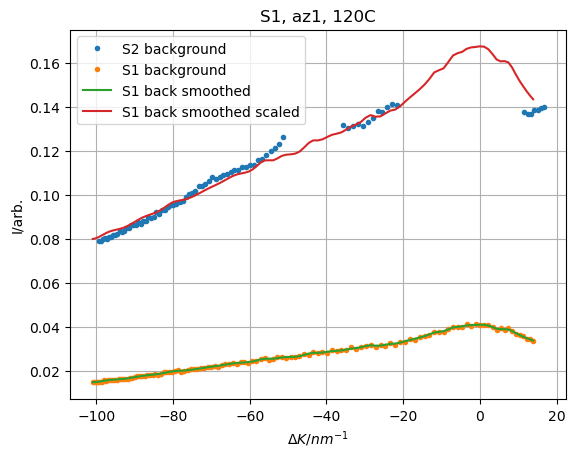

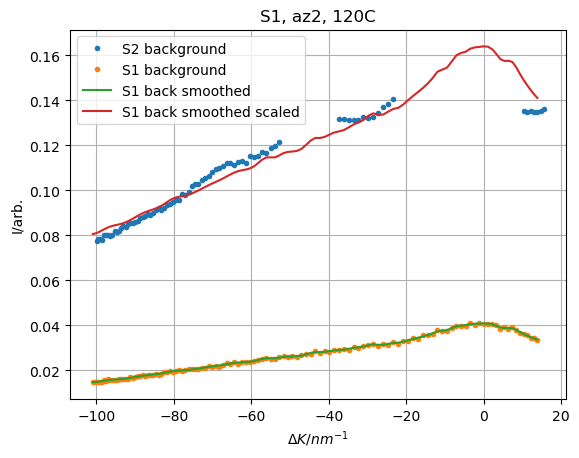

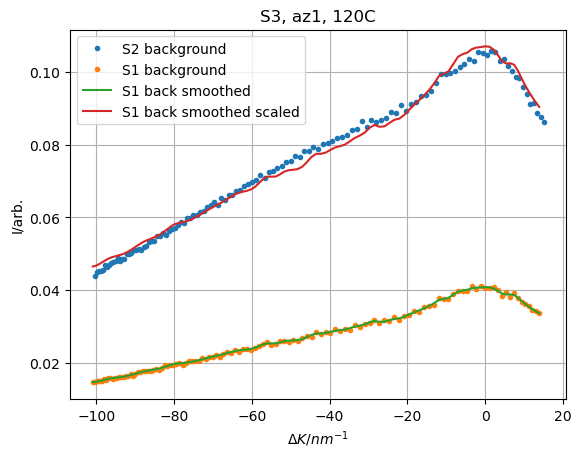

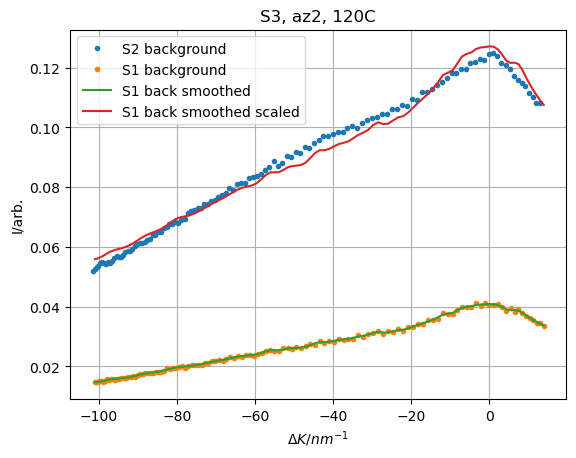

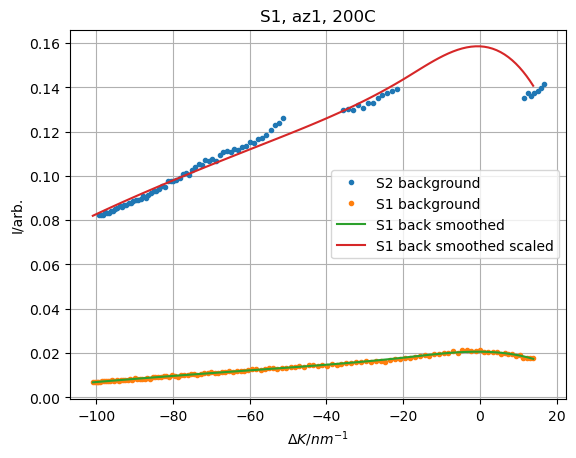

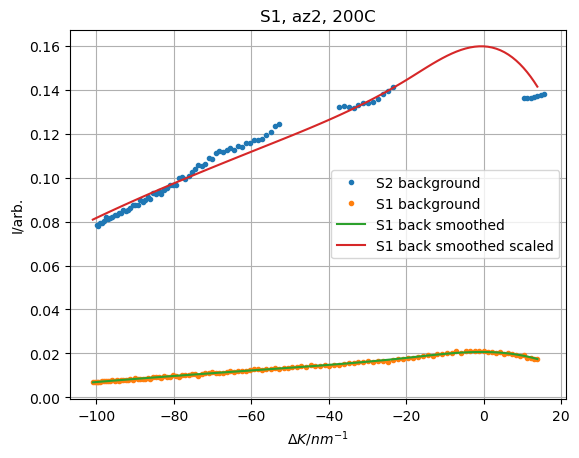

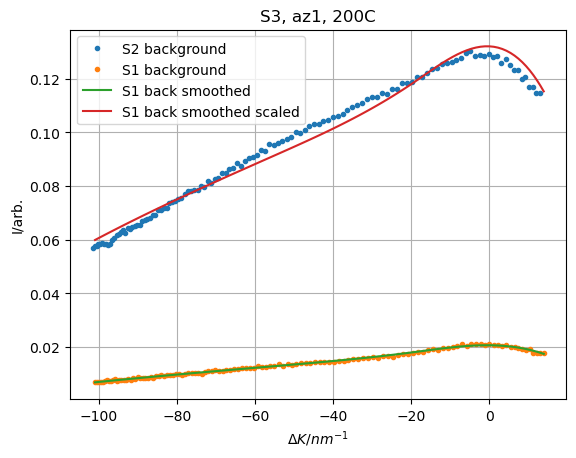

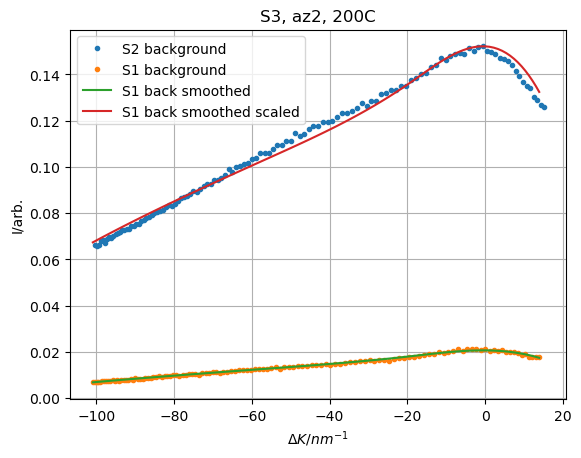

In [11]:
def background_matching(samp1_SiO2, samp2_SiO2):
    # The background for sample 3 as an x,y pair
    samp1_back = copy.deepcopy(samp1_SiO2)
    x_samp1 = samp1_back['DK'].to_numpy()
    y_samp1 = samp1_back['signal'].to_numpy()

    # The background for sample 2 as an x,y pair
    samp2_back = copy.deepcopy(samp2_SiO2)
    x_samp2 = samp2_back['DK'].to_numpy()
    y_samp2 = samp2_back['signal'].to_numpy()

    # Spline interpolation on sample 1
    ind = np.argsort(x_samp1)
    x_samp1 = x_samp1[ind]
    y_samp1 = y_samp1[ind]
    tck_s = splrep(x_samp1, y_samp1, s=0.00001)
    x2 = samp2_SiO2['DK'].to_numpy()
    x_max = np.min(np.array([np.max(x_samp1), np.max(x2)]))
    x_min = np.max(np.array([np.min(x_samp1), np.min(x2)]))
    ind = np.logical_and(x2 <= x_max, x2 >= x_min)
    x2 = x2[ind]
    y3 = BSpline(*tck_s)(x2)

    # Normalisation function to scale the smoothed background for sample 3
    # onto the background for sample 2, and hence the scale difference.
    norm_func = lambda x, beta, B1, B2: (BSpline(*tck_s)(x) - B2)/beta + B1
    norm_func2 = lambda I2, beta, B1, B2: (I2 - B2)/beta + B1 

    # Fit the smoothed background from sample 3 to the background for sample 2
    popt, pconv = optimize.curve_fit(norm_func, x_samp2, y_samp2)

    f, a = plt.subplots()
    a.plot(samp2_SiO2['DK'], samp2_SiO2['signal'], '.', label='S2 background')
    a.plot(x_samp1, y_samp1, '.', label='S1 background')
    a.plot(x_samp1, BSpline(*tck_s)(x_samp1), label='S1 back smoothed')
    a.plot(x_samp1, norm_func(x_samp1, *popt), label='S1 back smoothed scaled')
    a.set_xlabel('$\\Delta K/nm^{-1}$')
    a.set_ylabel('I/arb.')
    a.grid(True)
    a.set_title('Background correction used')
    a.legend()

    beta = popt[0]
    print("For sample 1 the detector was {} times as efficient as for sample 2".format(beta))
    print("Background values: B1 = {} and B2 = {}".format(popt[1], popt[2]))
    return((popt[0], popt[1], popt[2]))

dk = s2_az1_sio2_120['DK']
ind = (dk < -55) | ((dk < -25) & (dk > -40)) | ((dk < 15) & (dk > 8))

beta_s1a_az1_120, B1_s1a_az1_120, B2_s1a_az1_120 = background_matching(s2_az1_sio2_120, 
                                                                       s1a_az1_sio2_120[ind])
plt.title('S1, az1, 120C')
beta_s1a_az2_120, B1_s1a_az2_120, B2_s1a_az2_120 = background_matching(s2_az1_sio2_120, 
                                                                       s1a_az2_sio2_120[ind])
plt.title('S1, az2, 120C')
beta_s3_az1_120, B1_s3_az1_120, B2_s3_az1_120 = background_matching(s2_az1_sio2_120, 
                                                                    s3_az1_sio2_120)
plt.title('S3, az1, 120C')
beta_s3_az2_120, B1_s3_az2_120, B2_s3_az2_120 = background_matching(s2_az1_sio2_120, 
                                                                    s3_az2_sio2_120)
plt.title('S3, az2, 120C')

beta_s1a_az1_200, B1_s1a_az1_200, B2_s1a_az1_200 = background_matching(s2_az1_sio2_200, 
                                                                       s1a_az1_sio2_200[ind])
plt.title('S1, az1, 200C')
beta_s1a_az2_200, B1_s1a_az2_200, B2_s1a_az2_200 = background_matching(s2_az1_sio2_200, 
                                                                       s1a_az2_sio2_200[ind])
plt.title('S1, az2, 200C')
beta_s3_az1_200, B1_s3_az1_200, B2_s3_az1_200 = background_matching(s2_az1_sio2_200, 
                                                                    s3_az1_sio2_200)
plt.title('S3, az1, 200C')
beta_s3_az2_200, B1_s3_az2_200, B2_s3_az2_200 = background_matching(s2_az1_sio2_200, 
                                                                    s3_az2_sio2_200)
plt.title('S3, az2, 200C')

### Apply normalisation

Now apply the normalisation to the diffraction data. Plus add a correction to ensure the tail is averaged on 0.

In [12]:
ind = np.argsort(s2_az1_sio2_120['DK'])
x_samp = s2_az1_sio2_120['DK'][ind]
y_samp = s2_az1_sio2_120['signal'][ind]
tck_s = splrep(x_samp, y_samp, s=0.00001)
norm_func = lambda x, beta, B1, B2: (BSpline(*tck_s)(x) - B2)/beta + B1
norm_func2 = lambda I2, beta, B1, B2: (I2 - B2)/beta + B1 

# TODO: the 0.95 and 0.9 factors need to be aquired in a more standardised way....
# Use the tail of the distribution to get that parameter, the tail should end up being 0


s1a_az1_mos2_120_norm = s1a_az1_mos2_120.copy()
ind = (dk < -85) & (dk > -95)
fun = lambda x: abs(np.mean((s1a_az1_mos2_120_norm['signal'][ind]) - x*s1a_az1_sio2_120['signal'][ind]))
x1 = optimize.minimize(fun, 1)
print(x1.x)
s1a_az1_mos2_120_norm['signal'] = beta_s1a_az1_120*(s1a_az1_mos2_120_norm['signal'] - s1a_az1_sio2_120['signal']*x1.x)

s1a_az2_mos2_120_norm = s1a_az2_mos2_120.copy()
fun = lambda x: abs(np.mean((s1a_az2_mos2_120_norm['signal'][ind]) - x*s1a_az2_sio2_120['signal'][ind]))
x2 = optimize.minimize(fun, 1)
print(x2.x)
s1a_az2_mos2_120_norm['signal'] = beta_s1a_az2_120*(s1a_az2_mos2_120_norm['signal'] - s1a_az2_sio2_120['signal']*x2.x)

s3_az1_mos2_120_norm = s3_az1_mos2_120.copy()
fun = lambda x: abs(np.mean((s3_az1_mos2_120_norm['signal'][ind]) - x*s3_az1_sio2_120['signal'][ind]))
x3 = optimize.minimize(fun, 1)
print(x3.x)
s3_az1_mos2_120_norm['signal'] = beta_s3_az1_120*(s3_az1_mos2_120_norm['signal'] - s3_az1_sio2_120['signal']*x3.x)

s3_az2_mos2_120_norm = s3_az2_mos2_120.copy()
fun = lambda x: abs(np.mean((s3_az2_mos2_120_norm['signal'][ind]) - x*s3_az2_sio2_120['signal'][ind]))
x4 = optimize.minimize(fun, 1)
print(x4.x)
s3_az2_mos2_120_norm['signal'] = beta_s3_az2_120*(s3_az2_mos2_120_norm['signal'] - s3_az2_sio2_120['signal']*x4.x)

s2_az1_mos2_120_norm = s2_az1_mos2_120.copy()
fun = lambda x: abs(np.mean((s2_az1_mos2_120_norm['signal'][ind]) - x*s2_az1_sio2_120['signal'][ind]))
x5 = optimize.minimize(fun, 1)
print(x5.x)
s2_az1_mos2_120_norm['signal'] = s2_az1_mos2_120_norm['signal'] - s2_az1_sio2_120['signal']*x5.x


[0.90177738]
[0.99391154]
[0.96541369]
[0.955247]
[0.98487269]


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_29060/3955395824.py:8: SyntaxWarning: invalid escape sequence '\D'
  a.set_xlabel('$\Delta K/nm^{-1}$')


Text(0.5, 1.0, '120C data')

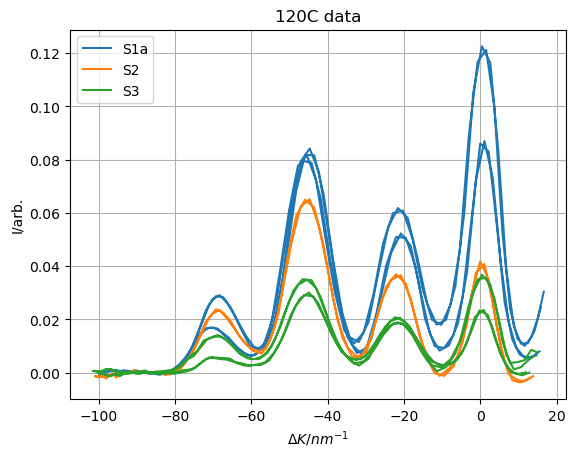

In [13]:
f, a = plt.subplots()
a.plot(s1a_az1_mos2_120_norm['DK'], s1a_az1_mos2_120_norm['signal'], label = 'S1a', color=colours[0])
a.plot(s1a_az2_mos2_120_norm['DK'], s1a_az2_mos2_120_norm['signal'], color=colours[0])
a.plot(s2_az1_mos2_120_norm['DK'], s2_az1_mos2_120_norm['signal'], label = 'S2', color=colours[1])
a.plot(s3_az1_mos2_120_norm['DK'], s3_az1_mos2_120_norm['signal'], label = 'S3', color=colours[2])
a.plot(s3_az2_mos2_120_norm['DK'], s3_az2_mos2_120_norm['signal'], color=colours[2])
a.grid(True)
a.set_xlabel('$\\Delta K/nm^{-1}$')
a.set_ylabel('I/arb.')
a.legend()
a.set_title('120C data')

In [14]:
ind = np.argsort(s2_az1_sio2_200['DK'])
x_samp = s2_az1_sio2_200['DK'][ind]
y_samp = s2_az1_sio2_200['signal'][ind]
tck_s = splrep(x_samp, y_samp, s=0.00001)
norm_func = lambda x, beta, B1, B2: (BSpline(*tck_s)(x) - B2)/beta + B1
norm_func2 = lambda I2, beta, B1, B2: (I2 - B2)/beta + B1 


s1a_az1_mos2_200_norm = s1a_az1_mos2_200.copy()
ind = (dk < -85) & (dk > -95)
fun = lambda x: abs(np.mean((s1a_az1_mos2_200_norm['signal'][ind]) - x*s1a_az1_sio2_200['signal'][ind]))
x1 = optimize.minimize(fun, 1)
print(x1.x)
s1a_az1_mos2_200_norm['signal'] = beta_s1a_az1_200*(s1a_az1_mos2_200_norm['signal'] - s1a_az1_sio2_200['signal']*x1.x)
s1a_az2_mos2_200_norm = s1a_az2_mos2_200.copy()
fun = lambda x: abs(np.mean((s1a_az2_mos2_200_norm['signal'][ind]) - x*s1a_az2_sio2_200['signal'][ind]))
x2 = optimize.minimize(fun, 1)
print(x2.x)
s1a_az2_mos2_200_norm['signal'] = beta_s1a_az2_200*(s1a_az2_mos2_200_norm['signal'] - s1a_az2_sio2_200['signal']*x2.x)

s3_az1_mos2_200_norm = s3_az1_mos2_200.copy()
fun = lambda x: abs(np.mean((s3_az1_mos2_200_norm['signal'][ind]) - x*s3_az1_sio2_200['signal'][ind]))
x3 = optimize.minimize(fun, 1)
print(x3.x)
s3_az1_mos2_200_norm['signal'] = beta_s3_az1_200*(s3_az1_mos2_200_norm['signal'] - s3_az1_sio2_200['signal']*x3.x)
s3_az2_mos2_200_norm = s3_az2_mos2_200.copy()
fun = lambda x: abs(np.mean((s3_az2_mos2_200_norm['signal'][ind]) - x*s3_az2_sio2_200['signal'][ind]))
x4 = optimize.minimize(fun, 1)
print(x4.x)
s3_az2_mos2_200_norm['signal'] = beta_s3_az2_200*(s3_az2_mos2_200_norm['signal'] - s3_az2_sio2_200['signal']*x4.x)

s2_az1_mos2_200_norm = s2_az1_mos2_200.copy()
fun = lambda x: abs(np.mean((s2_az1_mos2_200_norm['signal'][ind]) - x*s2_az1_sio2_200['signal'][ind]))
x5 = optimize.minimize(fun, 1)
print(x5.x)
s2_az1_mos2_200_norm['signal'] = s2_az1_mos2_200_norm['signal'] - s2_az1_sio2_200['signal']*x5.x

[0.91946058]
[0.99422522]
[0.96713991]
[0.92367054]
[0.9417921]


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_29060/635764763.py:8: SyntaxWarning: invalid escape sequence '\D'
  a.set_xlabel('$\Delta K/nm^{-1}$')


Text(0.5, 1.0, '200C data')

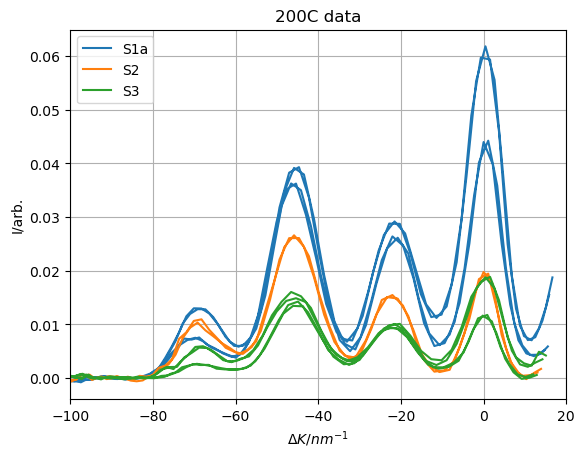

In [15]:
f, a = plt.subplots()
a.plot(s1a_az1_mos2_200_norm['DK'], s1a_az1_mos2_200_norm['signal'], label = 'S1a', color=colours[0])
a.plot(s1a_az2_mos2_200_norm['DK'], s1a_az2_mos2_200_norm['signal'], color=colours[0])
a.plot(s2_az1_mos2_200_norm['DK'], s2_az1_mos2_200_norm['signal'], label = 'S2', color=colours[1])
a.plot(s3_az1_mos2_200_norm['DK'], s3_az1_mos2_200_norm['signal'], label = 'S3', color=colours[2])
a.plot(s3_az2_mos2_200_norm['DK'], s3_az2_mos2_200_norm['signal'], color=colours[2])
a.grid(True)
a.set_xlabel('$\\Delta K/nm^{-1}$')
a.set_ylabel('I/arb.')
a.set_xlim(-100, 20)
a.legend()
a.set_title("200C data")

## 4. Fit Gaussian's to the data

The fit to the data is the sum of 4 Gaussians.

List of data:  
`s1a_az1_mos2_120_norm`  
`s1a_az1_mos2_120_norm`  
`s2_az1_mos2_120_norm`  
`s3_az1_mos2_120_norm`  
`s3_az1_mos2_120_norm`  

`s1a_az1_mos2_200_norm`  
`s1a_az1_mos2_200_norm`  
`s2_az1_mos2_200_norm`  
`s3_az1_mos2_200_norm`  
`s3_az1_mos2_200_norm`  

In [16]:
def gaussian(x, A, mu, sigma):
    y = A*np.exp(-(x - mu)**2/(2*sigma**2))
    return(y)

def gaussn(x, A, mu, sig):
    n = len(A)
    y = 0
    for i in range(n):
        y = y + gaussian(x, A[i], mu[i], sig[i])
    return(y)

def gaussn_wrap(x, N, *args):
    A, mu, sig = list(args[0][:N]), list(args[0][N:2*N]), list(args[0][2*N:3*N])
    return(gaussn(x, A, mu, sig))

gauss_tmp = lambda x, *params: gaussn_wrap(x, 4, params)

<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_29060/2959260010.py:23: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel('$\Delta K/\mathrm{nm}^{-1}$')


Lattice = 0.268nm +/- 0.014
Lattice = 0.273nm +/- 0.012
Lattice = 0.275nm +/- 0.005
Lattice = 0.271nm +/- 0.009
Lattice = 0.276nm +/- 0.007


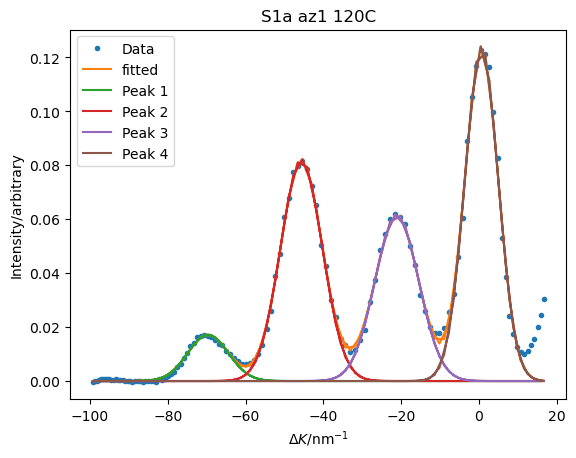

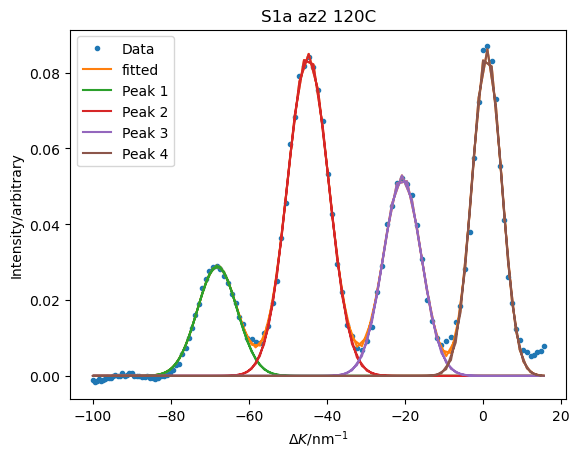

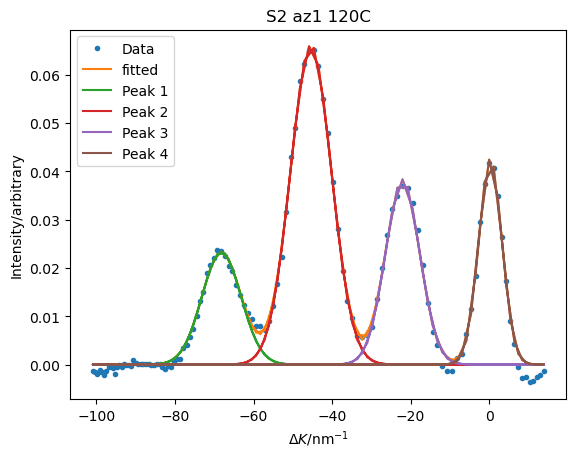

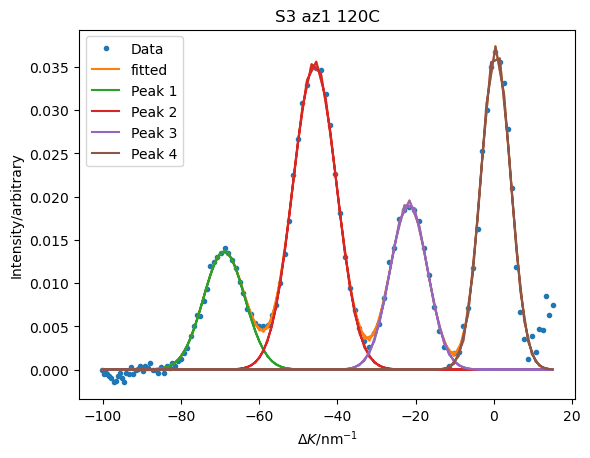

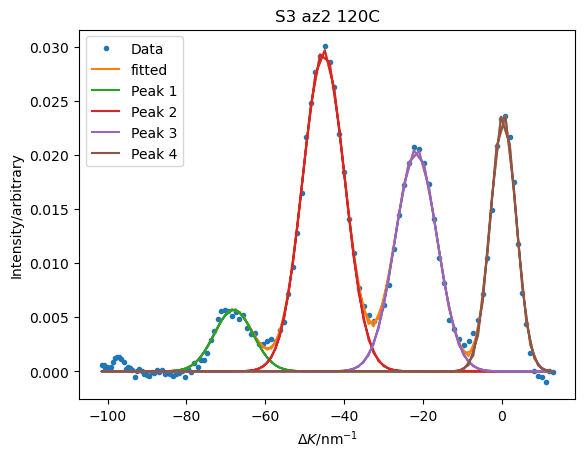

In [17]:
data_120 = [s1a_az1_mos2_120_norm, s1a_az2_mos2_120_norm, s2_az1_mos2_120_norm, 
            s3_az1_mos2_120_norm, s3_az2_mos2_120_norm]
data_200 = [s1a_az1_mos2_200_norm, s1a_az2_mos2_200_norm, s2_az1_mos2_200_norm, 
            s3_az1_mos2_200_norm, s3_az2_mos2_200_norm]
names = ['S1a az1 120C', 'S1a az2 120C', 'S2 az1 120C', 'S3 az1 120C', 'S3 az2 120C']
names2 = ['S1a az1 200C', 'S1a az2 200C', 'S2 az1 200C', 'S3 az1 200C', 'S3 az2 200C']

peaks_120 = []
lattice_120 = []
heights_120 = []
for j in range(len(data_120)):
    data = data_120[j]
    p0 = [0.015, 0.04, 0.028, 0.03, -70, -45, -22, 0, 3, 3, 3, 3]
    popt_g, pcov = optimize.curve_fit(gauss_tmp, data['DK'], data['signal'], p0 = p0)

    f, ax = plt.subplots()
    ax.plot(data['DK'], data['signal'], label='Data', marker ='.', linestyle='None')
    ax.plot(data['DK'], gauss_tmp(data['DK'], *popt_g), label='fitted')
    for i in range(4):
        ax.plot(data['DK'], gaussian(data['DK'], popt_g[i], popt_g[i+4], popt_g[i+2*4]), 
                label='Peak {}'.format(i+1))
    ax.legend()
    ax.set_xlabel('$\\Delta K/\\mathrm{nm}^{-1}$')
    ax.set_ylabel('Intensity/arbitrary')
    ax.set_title(names[j])

    # Peak heights and standard deviations
    heights = popt_g[0:4]
    stds = abs(popt_g[8:12]) # Sometimes the fitting can give -ve sigma...
    areas_samp3 = heights*stds*np.sqrt(2*np.pi)

    sigma = np.std(np.diff([popt_g[4:8]]))
    G = np.mean(np.diff(popt_g[4:8]))
    a = 2*np.pi/(G)
    print('Lattice = {:.3f}nm +/- {:.3f}'.format(a, a*sigma/G))
    lattice_120.append((a, a*sigma/G))
    peaks_120.append(areas_samp3)
    heights_120.append(heights)

8.653257418607217e-20
[0.00865326 0.0536502  0.15575863]
51.95179034444638 A^2
29.837468815544558 A^2
24.854226783174695 A^2
21.11643822149349 A^2
03 peak = [0.02317976 0.02338452 0.00974511]
02 peak = [0.08361493 0.06618297 0.03269255]
01 peak = [0.05736231 0.0383422  0.02004882]
00 peak = [0.10515917 0.04264504 0.0306422 ]
03 peak err = [0.00592994 0.         0.0040084 ]
02 peak err = [0.00133052 0.         0.00299327]
01 peak err = [0.00447248 0.         0.0004871 ]
00 peak err = [0.0190249  0.         0.00674376]
[0.1  0.62 1.8 ]


<>:42: SyntaxWarning: invalid escape sequence '\T'
<>:42: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_29060/927792135.py:42: SyntaxWarning: invalid escape sequence '\T'
  a.set_xlabel('$\Theta$')


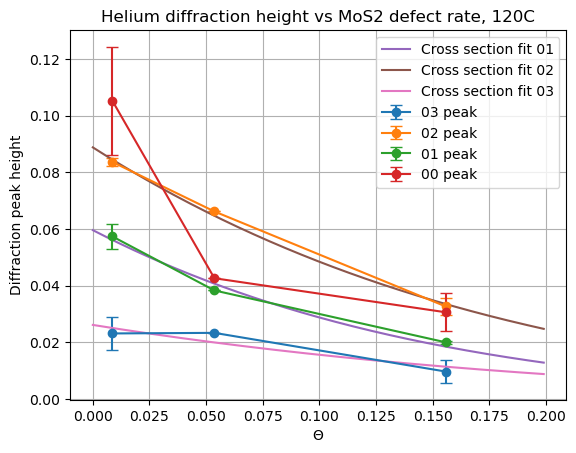

In [18]:
diff_03 = np.array([heights_120[0][0], heights_120[1][0], heights_120[2][0], heights_120[3][0], heights_120[4][0]])
diff_02 = np.array([heights_120[0][1], heights_120[1][1], heights_120[2][1], heights_120[3][1], heights_120[4][1]])
diff_01 = np.array([heights_120[0][2], heights_120[1][2], heights_120[2][2], heights_120[3][2], heights_120[4][2]])
diff_00 = np.array([heights_120[0][3], heights_120[1][3], heights_120[2][3], heights_120[3][3], heights_120[4][3]])
defect = np.array([1, 1, 2, 3, 3])

diff03 = np.array([(diff_03[0] + diff_03[1])/2, diff_03[2], (diff_03[3] + diff_03[4])/2])
diff03_err = np.array([abs(diff_03[0] - diff_03[1])/2, 0, abs(diff_03[3] - diff_03[4])/2])
diff02 = np.array([(diff_02[0] + diff_02[1])/2, diff_02[2], (diff_02[3] + diff_02[4])/2])
diff02_err = np.array([abs(diff_02[0] - diff_02[1])/2, 0, abs(diff_02[3] - diff_02[4])/2])
diff01 = np.array([(diff_01[0] + diff_01[1])/2, diff_01[2], (diff_01[3] + diff_01[4])/2])
diff01_err = np.array([abs(diff_01[0] - diff_01[1])/2, 0, abs(diff_01[3] - diff_01[4])/2])
diff00 = np.array([(diff_00[0] + diff_00[1])/2, diff_00[2], (diff_00[3] + diff_00[4])/2])
diff00_err = np.array([abs(diff_00[0] - diff_00[1])/2, 0, abs(diff_00[3] - diff_00[4])/2])

defect1 = np.array([1, 2, 3])
ns = 1/(8.648/2)

cross = lambda theta, I0, sigma: I0*(1 - theta)**(sigma*ns)

defect_rate = np.array([0.1, 0.62, 1.8])*1e14
A = (0.3161e-9)**2 *np.cos(30*np.pi/180)*np.cos(60*np.pi/180)
print(A*2)
theta = (defect_rate*1e2*1e2)*2*A
print(theta)
popt1, pcov1 = optimize.curve_fit(cross, theta, diff01, p0 = [0.1, 40])

popt2, pcov2 = optimize.curve_fit(cross, theta, diff02, p0 = [0.12, 40])
popt3, pcov3 = optimize.curve_fit(cross, theta, diff03, p0 = [0.12, 40])
popt0, pcov0 = optimize.curve_fit(cross, theta, diff00, p0 = [0.12, 40])
x = np.arange(0, 0.2, 0.001)

f, a = plt.subplots()
a.errorbar(theta, diff03, diff03_err, fmt='o-', capsize=4, label='03 peak')
a.errorbar(theta, diff02, diff02_err, fmt='o-', capsize=4, label='02 peak')
a.errorbar(theta, diff01, diff01_err, fmt='o-', capsize=4, label='01 peak')
a.errorbar(theta, diff00, diff00_err, fmt='o-', capsize=4, label='00 peak')
a.plot(x, cross(x, *popt1), label = 'Cross section fit 01')
a.plot(x, cross(x, *popt2), label = 'Cross section fit 02')
a.plot(x, cross(x, *popt3), label = 'Cross section fit 03')
#a.errorbar(defect_rate, diff00, diff00_err, fmt='o-',  capsize=4, label='00 peak')
a.set_xlabel('$\Theta$')
a.set_ylabel('Diffraction peak height')
a.set_title('Helium diffraction height vs MoS2 defect rate, 120C')
a.grid(True)
a.legend()

print('{} A^2'.format(popt0[1]))
print('{} A^2'.format(popt1[1]))
print('{} A^2'.format(popt2[1]))
print('{} A^2'.format(popt3[1]))
print('03 peak = {}'.format(diff03))
print('02 peak = {}'.format(diff02))
print('01 peak = {}'.format(diff01))
print('00 peak = {}'.format(diff00))
print('03 peak err = {}'.format(diff03_err))
print('02 peak err = {}'.format(diff02_err))
print('01 peak err = {}'.format(diff01_err))
print('00 peak err = {}'.format(diff00_err))
print(defect_rate*1e-14)

In [19]:
print(np.sqrt(pcov1[1,1]), np.sqrt(pcov2[1,1]), np.sqrt(pcov3[1,1]))

4.4468035287837235 1.6171206582821822 10.79356910697732


In [20]:
print('{} A^2'.format(popt1[1]))
print('{} A^2'.format(popt2[1]))


29.837468815544558 A^2
24.854226783174695 A^2


In [21]:
A = (0.3161e-9)**2 *np.cos(30*np.pi/180)*np.cos(60*np.pi/180)
A*2

np.float64(8.653257418607217e-20)

In [22]:
spec = heights_120[0][3] + heights_120[1][3]
print((heights_120[0] + heights_120[1])/spec)
# 0.22, 0.80, 0.55, 1
# -30, -20, -10, 00

[0.22042544 0.79512738 0.54548085 1.        ]


<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_29060/1003720458.py:15: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel('$\Delta K/\mathrm{nm}^{-1}$')


0
S1a az1 200C
Lattice = 0.271nm +/- 0.015
1
S1a az2 200C
Lattice = 0.274nm +/- 0.012
2
S2 az1 200C
Lattice = 0.276nm +/- 0.006
3
S3 az1 200C
Lattice = 0.278nm +/- 0.007
4
S3 az2 200C
Lattice = 0.276nm +/- 0.013


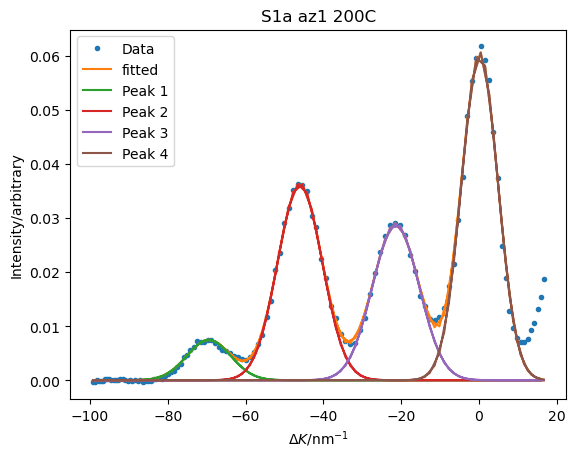

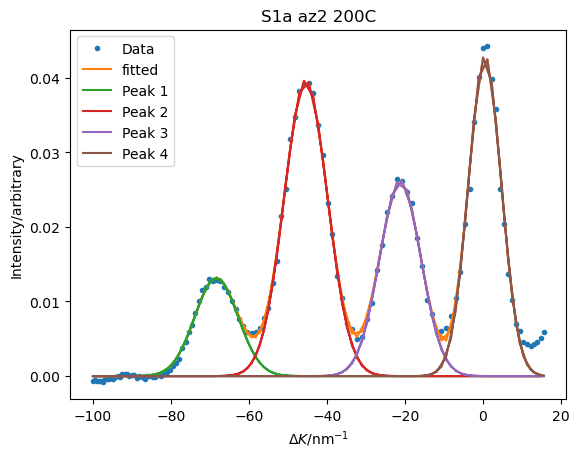

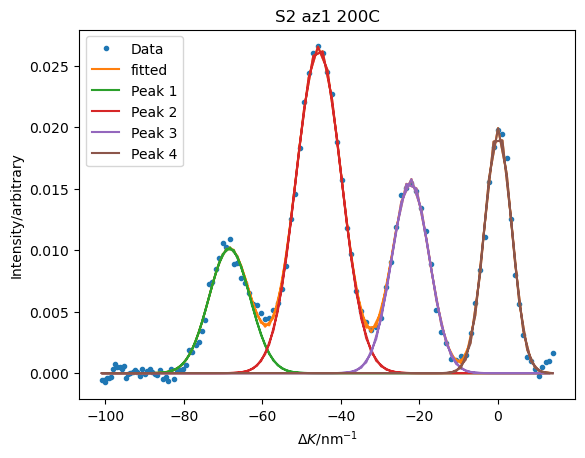

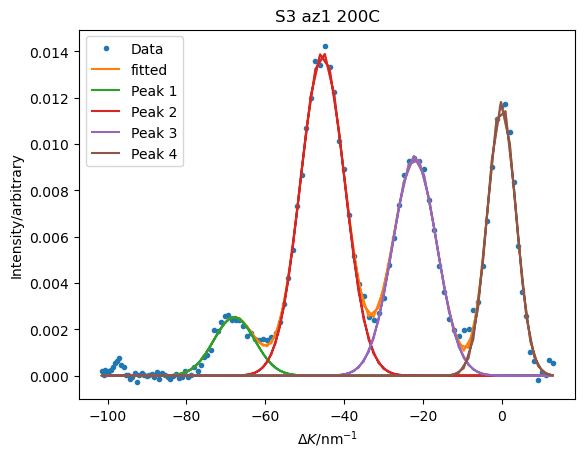

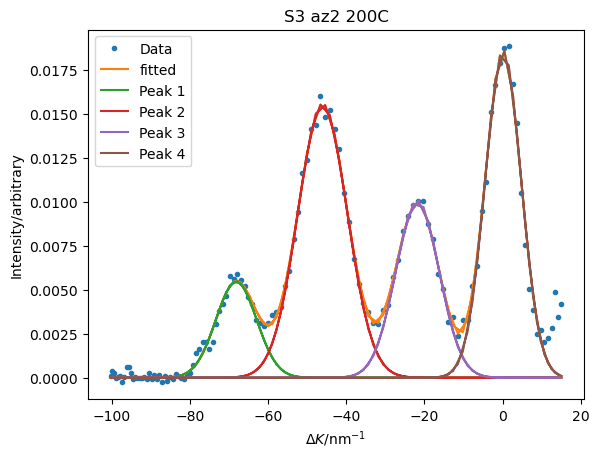

In [23]:
peaks_200 = []
lattice_200 = []
heights_200 = []
#print(data_200)
for i, data in enumerate(data_200):
    p0 = [0.015, 0.04, 0.028, 0.03, -70, -45, -22, 0, 3, 3, 3, 3]
    popt_g, pcov = optimize.curve_fit(gauss_tmp, data['DK'], data['signal'], p0 = p0)

    f, ax = plt.subplots()
    ax.plot(data['DK'], data['signal'], label='Data', marker ='.', linestyle='None')
    ax.plot(data['DK'], gauss_tmp(data['DK'], *popt_g), label='fitted')
    for j in range(4):
        ax.plot(data['DK'], gaussian(data['DK'], popt_g[j], popt_g[j+4], popt_g[j+2*4]), label='Peak {}'.format(j+1))
    ax.legend()
    ax.set_xlabel('$\\Delta K/\\mathrm{nm}^{-1}$')
    ax.set_ylabel('Intensity/arbitrary')
    ax.set_title(names2[i])
    print(i)
    print(names2[i])

    # Peak heights and standard deviations
    heights = popt_g[0:4]
    stds = popt_g[8:12]
    areas_samp3 = heights*stds*np.sqrt(2*np.pi)

    sigma = np.std(np.diff([popt_g[4:8]]))
    G = np.mean(np.diff(popt_g[4:8]))
    a = 2*np.pi/G
    print('Lattice = {:.3f}nm +/- {:.3f}'.format(a, a*sigma/G))
    lattice_200.append((a, a*sigma/G))
    peaks_200.append(areas_samp3)
    heights_200.append(heights)

8.653257418607217e-20
[0.00865326 0.0536502  0.15575863]
55.239682179561285 A^2
32.44034191129547 A^2
26.5890180442619 A^2
22.77466956903637 A^2
03 peak = [0.01036256 0.01022299 0.00402238]
02 peak = [0.03810552 0.02656038 0.01476155]
01 peak = [0.02769328 0.01579343 0.0097691 ]
00 peak = [0.05185162 0.01992013 0.01521399]
03 peak err = [0.0028503  0.         0.00147838]
02 peak err = [0.00161863 0.         0.00080933]
01 peak err = [0.00138404 0.         0.0002877 ]
00 peak err = [0.00888068 0.         0.00339192]
[0.1  0.62 1.8 ]


<>:42: SyntaxWarning: invalid escape sequence '\T'
<>:42: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_29060/3577056069.py:42: SyntaxWarning: invalid escape sequence '\T'
  a.set_xlabel('$\Theta$')


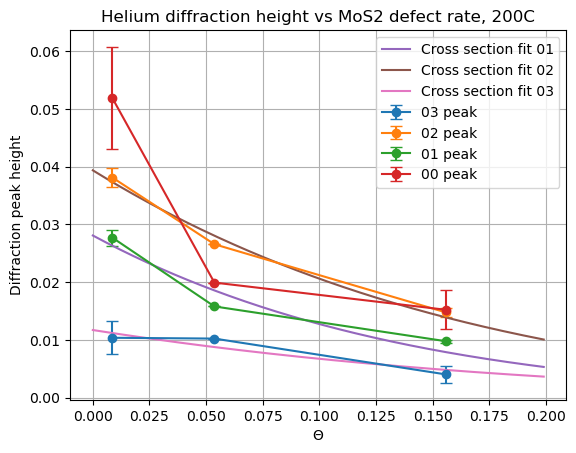

In [24]:
diff_03 = np.array([heights_200[0][0], heights_200[1][0], heights_200[2][0], heights_200[3][0], heights_200[4][0]])
diff_02 = np.array([heights_200[0][1], heights_200[1][1], heights_200[2][1], heights_200[3][1], heights_200[4][1]])
diff_01 = np.array([heights_200[0][2], heights_200[1][2], heights_200[2][2], heights_200[3][2], heights_200[4][2]])
diff_00 = np.array([heights_200[0][3], heights_200[1][3], heights_200[2][3], heights_200[3][3], heights_200[4][3]])
defect = np.array([1, 1, 2, 3, 3])

diff03 = np.array([(diff_03[0] + diff_03[1])/2, diff_03[2], (diff_03[3] + diff_03[4])/2])
diff03_err = np.array([abs(diff_03[0] - diff_03[1])/2, 0, abs(diff_03[3] - diff_03[4])/2])
diff02 = np.array([(diff_02[0] + diff_02[1])/2, diff_02[2], (diff_02[3] + diff_02[4])/2])
diff02_err = np.array([abs(diff_02[0] - diff_02[1])/2, 0, abs(diff_02[3] - diff_02[4])/2])
diff01 = np.array([(diff_01[0] + diff_01[1])/2, diff_01[2], (diff_01[3] + diff_01[4])/2])
diff01_err = np.array([abs(diff_01[0] - diff_01[1])/2, 0, abs(diff_01[3] - diff_01[4])/2])
diff00 = np.array([(diff_00[0] + diff_00[1])/2, diff_00[2], (diff_00[3] + diff_00[4])/2])
diff00_err = np.array([abs(diff_00[0] - diff_00[1])/2, 0, abs(diff_00[3] - diff_00[4])/2])

defect1 = np.array([1, 2, 3])
ns = 1/(8.648/2)

cross = lambda theta, I0, sigma: I0*(1 - theta)**(sigma*ns)

defect_rate = np.array([0.1, 0.62, 1.8])*1e14
A = (0.3161e-9)**2 *np.cos(30*np.pi/180)*np.cos(60*np.pi/180)
print(A*2)
theta = (defect_rate*1e2*1e2)*2*A
print(theta)
popt1, pcov1 = optimize.curve_fit(cross, theta, diff01, p0 = [0.1, 40])

popt2, pcov2 = optimize.curve_fit(cross, theta, diff02, p0 = [0.12, 40])
popt3, pcov3 = optimize.curve_fit(cross, theta, diff03, p0 = [0.12, 40])
popt0, pcov0 = optimize.curve_fit(cross, theta, diff00, p0 = [0.12, 40])
x = np.arange(0, 0.2, 0.001)

f, a = plt.subplots()
a.errorbar(theta, diff03, diff03_err, fmt='o-', capsize=4, label='03 peak')
a.errorbar(theta, diff02, diff02_err, fmt='o-', capsize=4, label='02 peak')
a.errorbar(theta, diff01, diff01_err, fmt='o-', capsize=4, label='01 peak')
a.errorbar(theta, diff00, diff00_err, fmt='o-', capsize=4, label='00 peak')
a.plot(x, cross(x, *popt1), label = 'Cross section fit 01')
a.plot(x, cross(x, *popt2), label = 'Cross section fit 02')
a.plot(x, cross(x, *popt3), label = 'Cross section fit 03')
#a.errorbar(defect_rate, diff00, diff00_err, fmt='o-',  capsize=4, label='00 peak')
a.set_xlabel('$\Theta$')
a.set_ylabel('Diffraction peak height')
a.set_title('Helium diffraction height vs MoS2 defect rate, 200C')
a.grid(True)
a.legend()

print('{} A^2'.format(popt0[1]))
print('{} A^2'.format(popt1[1]))
print('{} A^2'.format(popt2[1]))
print('{} A^2'.format(popt3[1]))
print('03 peak = {}'.format(diff03))
print('02 peak = {}'.format(diff02))
print('01 peak = {}'.format(diff01))
print('00 peak = {}'.format(diff00))
print('03 peak err = {}'.format(diff03_err))
print('02 peak err = {}'.format(diff02_err))
print('01 peak err = {}'.format(diff01_err))
print('00 peak err = {}'.format(diff00_err))
print(defect_rate*1e-14)